### Random Forest Regressor

### Step 1: Import libraries

In [2]:
# import stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from sklearn import metrics
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from math import sqrt
import TEpython_Parallel
import os

### Step 2: Read data (note: no explicit transformation for null model)

In [3]:
# read in all csv files in working directory
dfs = [pd.read_csv(f, header = 0,index_col = 'DateTime',parse_dates = True, infer_datetime_format = True,low_memory=False)
        for f in os.listdir(os.getcwd()) if f.endswith('csv')]
# merge all time series data with datetime as index
table = pd.concat(dfs, axis=1, join='outer').sort_index()
table = table.dropna() # drop rows that have na data
# drop non-relevent columns using keywords
l1 = ['350', '250', '625_precip', 'VMC', '_ST', 'humidity', 'dewPoint', 'solar', 'Pressure', 'Deficit', 'snow', 'swe', 'VANMET', 'AirTemp'] #partial names of columns to drop
for i in l1:
    table.drop([col for col in table.columns if i in col],axis=1, inplace=True)
# calculate the 7 day rolling mean precipitation
l2 = ['CENMET_455_precip', 'CS2MET_260_precip', 'H15MET_410_precip', 'PRIMET_100_precip','UPLMET_455_precip', 'VARMET_455_precip']
for j in l2:
    table[j+'7d_average']=table[j].rolling(7).mean()
    table=table.drop(columns=[j])   # drop daily precipitation data 
table = table.dropna() 
table = table.loc[:,~table.columns.duplicated()] # this leaves only one discharge column

print(table.shape)
nRows = int(table.shape[0])
nCols = int(table.shape[1])

table.head(5)


(973, 7)


,GSLOOK_discharge,CENMET_455_precip7d_average,CS2MET_260_precip7d_average,H15MET_410_precip7d_average,PRIMET_100_precip7d_average,UPLMET_455_precip7d_average,VARMET_455_precip7d_average
DateTime,,,,,,,
2011-07-01,50.0,1.885714,2.142857,2.100000,2.200000,1.900000,2.171429
2011-07-02,48.0,1.885714,2.142857,2.100000,2.200000,1.914286,2.157143
2011-07-03,46.0,1.885714,2.142857,2.100000,2.200000,1.914286,2.157143
2011-07-04,44.0,1.714286,1.957143,1.900000,1.985714,1.657143,2.014286
2011-07-05,41.0,0.414286,0.142857,0.685714,0.257143,0.628571,0.971429


In [4]:
# get predictor names
colnames = list(table.columns)
varnames = colnames[1:nCols]
varnames

['CENMET_455_precip7d_average',
 'CS2MET_260_precip7d_average',
 'H15MET_410_precip7d_average',
 'PRIMET_100_precip7d_average',
 'UPLMET_455_precip7d_average',
 'VARMET_455_precip7d_average']

### Step 3: Separate predictors and response variable

In [5]:
# separate variables
discharge = table.GSLOOK_discharge.values
predictors = table.iloc[:,1:nCols].values
predictors[0:1,:]


array([[1.88571429, 2.14285714, 2.1       , 2.2       , 1.9       ,
        2.17142857]])

In [6]:
# Note: no scaling needed for decision trees
# X
X = predictors
X[0:1,:]

array([[1.88571429, 2.14285714, 2.1       , 2.2       , 1.9       ,
        2.17142857]])

In [7]:
# Y
Y = discharge

### Step 4: Split data into training and test set

In [8]:
# separate train and test data
train_fraction = 0.75
train_length = int(nRows * train_fraction)
test_length = nRows-train_length
#
train_X = X[:train_length,:]
train_Y = Y[:train_length]
test_X = X[train_length:,:]
test_Y = Y[train_length:]
train_X[0:1,:]


array([[1.88571429, 2.14285714, 2.1       , 2.2       , 1.9       ,
        2.17142857]])

### Step 5: Setup cross-validation, estimator, and parameter search

In [9]:
# define k-fold and number of parallel jobs
nFold = 5
nJobs = 10

In [10]:
# setup default estimator
#myRFR = RandomForestRegressor(n_estimators=100, n_jobs-1, max_features='sqrt', min_samples_split=5, 
#    min_samples_leaf=50, min_impurity_split=1e-07, criterion=’mse’)

# estimators: number of trees
myRFR = RandomForestRegressor(criterion='mse', verbose=3)


## Important parameters:

n_estimators : integer, optional (default=10)

    The number of trees in the forest.

criterion : string, optional (default=”mse”)

    The function to measure the quality of a split. 
    
max_depth : integer or None, optional (default=None)

    The maximum depth of the tree. 
    
min_samples_split : int, float, optional (default=2)

    The minimum number of samples required to split an internal node:

min_samples_leaf : int, float, optional (default=1)

    The minimum number of samples required to be at a leaf node. 

min_impurity_decrease : float, optional (default=0.)

    A node will be split if this split induces a decrease of the impurity greater than or equal to this value.

min_impurity_split : float, (default=1e-7)

    Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.



In [11]:
# parameters to test in grid search / cross validation
myRFR_params = { 
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt','log2'],
    'max_depth' : [2,3,4,5,10],
    'min_samples_split' : [2,3,4,5,10],
    'min_samples_leaf' : [2,5,10,50]}
myRFR_params


{'n_estimators': [50, 100, 200],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [2, 3, 4, 5, 10],
 'min_samples_split': [2, 3, 4, 5, 10],
 'min_samples_leaf': [2, 5, 10, 50]}

### Step 6: Perform parameter search, fit estimator

In [12]:
# do parameter space search
# myRFR_CV = GridSearchCV(estimator=myRFR, param_grid=param_grid, cv= nFold)
# GridSearchCV(estimator, param_grid, scoring=None, fit_params=None, n_jobs=None, iid=’warn’, refit=True, cv=’warn’, verbose=0, pre_dispatch=‘2*n_jobs’, error_score=’raise-deprecating’, return_train_score=’warn’)
myRFR_CV = GridSearchCV(estimator=myRFR, param_grid=myRFR_params, cv=nFold, n_jobs=nJobs, verbose=3, refit=True)
myRFR_CV.fit(train_X, train_Y)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    8.9s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:   22.0s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   34.1s
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed:   54.1s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 1548 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 2028 tasks      | elapsed:  3.1min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  3.9min
[Parallel(n_jobs=10)]: Done 3000 out of 3000 | elapsed:  4.5min finished
C:\Users\Jules\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Deprec

building tree 1 of 50


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 2 of 50


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 o

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.1s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=3, warm_start=False),
             iid='warn', n_jobs=10,
             param_grid={'max_depth': [2, 3, 4, 5, 10],
  

In [13]:
myRFR_CV.best_params_

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 50}

### Step 7: Train and test using optimized estimator

In [14]:
# train and test
myRFR_test_pred = myRFR_CV.predict(test_X)
myRFR_train_pred = myRFR_CV.predict(train_X)

# eliminate negative predictions
myRFR_train_pred_copy = myRFR_train_pred.copy()
myRFR_test_pred_copy = myRFR_test_pred.copy()
myRFR_train_pred[myRFR_train_pred<0] = 0
myRFR_test_pred[myRFR_test_pred<0] = 0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


### Step 8: Compute error

In [15]:
def logNS(o,s):
    """
    Nash Sutcliffe efficiency coefficient
    input:
        s: simulated
        o: observed
    output:
        ns: Nash Sutcliffe efficient coefficient
    """
    eps = 1e-5
    return 1 - sum((np.log(s+eps)-np.log(o+eps))**2)/sum((np.log(o+eps)-np.mean(np.log(o+eps)))**2) 

# compute error
RMSE = np.sqrt(metrics.mean_squared_error(test_Y, myRFR_test_pred))
EVS = metrics.explained_variance_score(test_Y, myRFR_test_pred)
R2 = metrics.r2_score(test_Y, myRFR_test_pred)
NS = logNS(test_Y, myRFR_test_pred)

print('RMSE:', RMSE)
print('EVS:', EVS)
print('R2:', R2)
print('NS:', NS)

RMSE: 124.79302605882145
EVS: 0.4932786495608903
R2: 0.4920387108269524
NS: 0.5070179388303635


### Step 9: plot results

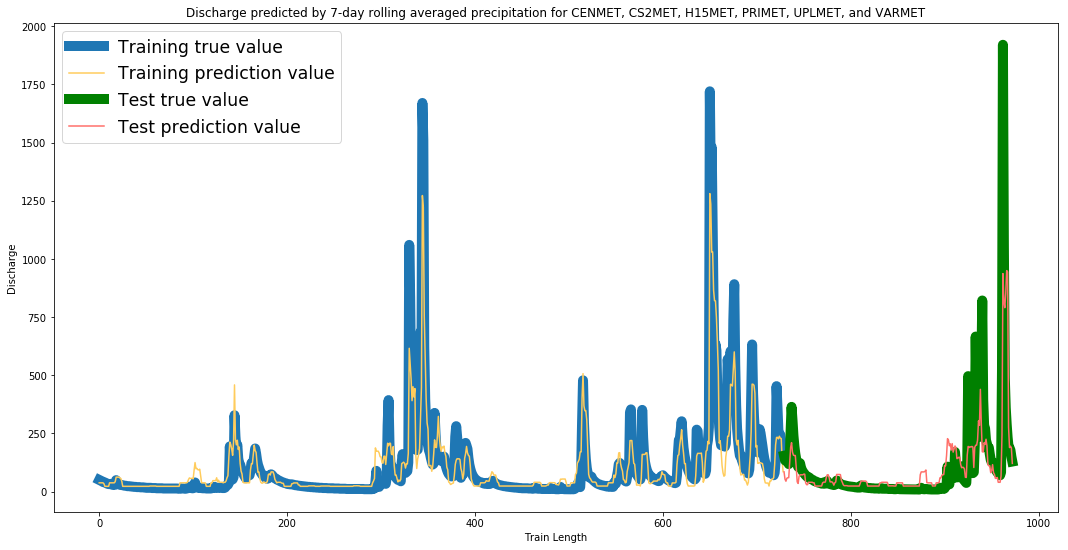

In [17]:
plt.figure(figsize=(18,9))
plt.plot(np.arange(train_length), train_Y, label='Training true value', lw=10)
plt.plot(np.arange(train_length), myRFR_train_pred, label='Training prediction value', color='#ffcc5c')
plt.plot(np.arange(train_length,nRows), test_Y, label='Test true value', lw=10, c='g')
plt.plot(np.arange(train_length,nRows), myRFR_test_pred, label='Test prediction value', color='#ff6f69')
plt.title('Discharge predicted by 7-day rolling averaged precipitation for CENMET, CS2MET, H15MET, PRIMET, UPLMET, and VARMET')
plt.xlabel("Train Length")
plt.ylabel("Discharge")
plt.legend(fontsize='xx-large')


### Step 10: get variable importance (RFR only)

In [18]:
importance = pd.DataFrame(myRFR_CV.best_estimator_.feature_importances_,index = varnames, columns=['Importance'])
importance.sort_values(by='Importance', ascending=False).head(30)

,Importance
PRIMET_100_precip7d_average,0.241521
CS2MET_260_precip7d_average,0.233201
H15MET_410_precip7d_average,0.187663
CENMET_455_precip7d_average,0.149214
UPLMET_455_precip7d_average,0.123192
VARMET_455_precip7d_average,0.065208


### Step 11: compute Mutual Information between observed and model

In [19]:
# stack observed and model into a matrix
DataMat = np.column_stack((test_Y,myRFR_test_pred))

# compute mutual information
nbins = [11,11,11]
MutInfoQobsVSQmod = TEpython_Parallel.mutinfo_new(DataMat,nbins)
print('Mutual Information, I = ', MutInfoQobsVSQmod*100, '%') # I/H

Mutual Information, I =  34.82956401767735 %
